In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import resample
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg
)
from truth import IeeeGroundTruth

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [56]:
truth = IeeeGroundTruth(1, 1, directory = 'channel_data3')  # basic method

truth.align_rgb_bvp()
truth.fill_nans()
truth.process_rgb()
truth.process_bvp()

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


class RppgMl:
    
    def __init__(self, data, label_col = 'bvp', test_size = 0.2, random_state = 0):

        self.data = data
        self.label_col = label_col
        self.test_size = test_size
        self.random_state = random_state

        self.X = self.data.drop(columns = [self.label_col])
        self.y = self.data[self.label_col]
        
        (
            self.X_train, self.X_test,
            self.y_train, self.y_test
        ) = train_test_split(self.X, self.y, test_size = self.test_size, random_state = self.random_state)

        self.X_train = self.X_train.to_numpy()
        self.X_test = self.X_test.to_numpy()
        self.y_train = self.y_train.to_numpy()
        self.y_test = self.y_test.to_numpy()
    
    def train_skl(self, model):
        self.skl_model = model(random_state = self.random_state)
        self.skl_model.fit(self.X_train, self.y_train)

    def predict_skl(self, x):
        return self.skl_model.predict(x)
    
    def eval_skl(self):
        return mean_squared_error(self.y_test, self.predict_skl(self.X_test))

In [58]:
data = truth.prepare_data_for_ml()#.iloc[1000: 3000, :]
ml = RppgMl(data)
ml.train_skl(RandomForestRegressor)
ml.eval_skl()

0.001857670206386907

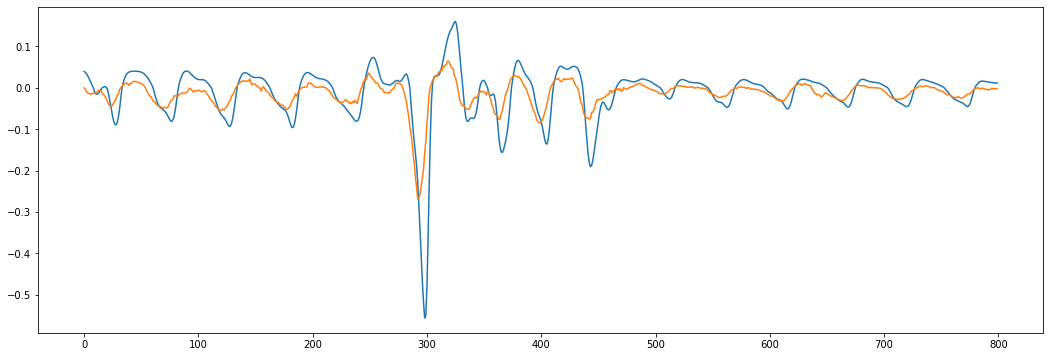

In [67]:
pred = ml.predict_skl(ml.X.to_numpy())
pred = n_moving_avg(pred, 10)
orig = len(pred)
pred = resample(pred, len(data.bvp))
plt.plot(data.bvp.to_numpy()[1000: 1800])
plt.plot(pred[1000: 1800])
